In [4]:
import numpy as np

class GlucoseDynamicsSimulator:
    """
    Meals are represented by Rameal(t), the rate of glucose appearance from the gut
    Exercise is represented by E_t, e.g. 0 to 1
    Meal and exercise events are represented by boolean flags
    Inputs: 
        Rameal_current, E_current, meal_event_occurred, exercise_event_occurred
    State variables:
        G: glucose concentration in the central compartment [mg/dL]
        H: glucose concentration in the skeletal muscle [mg/dL]
        S: interstitial insulin concentration in skeletal muscle [uU/ml]
        M: liver glucose consumption state [unitless]
        L: exercise-action intensity [unitless]
        I_plasma: Plasma insulin concentration [uU/ml]
    Parameterized variables:
        weight [kg]
        Gb: basal glucose concentration [mg/dL]
        Ib: basal insulin concentration [mU/L]
    """

    def __init__(self, weight=70, Gb=90, Ib=15):
        self.weight = weight
        self.Gb = Gb
        self.Ib = Ib

        # metabolic rates [mg/min]
        self.rG_brain = 71
        self.rG_heart = 3.7
        self.rG_kidney = 3.7
        self.rG_gut = 16.6
        self.rG_peri = 45.2 * (self.weight / 70)
        self.rG_liver = 14.8 * (self.weight / 70)

        # EGP basal
        self.EGPb = 155 * (self.weight / 70)  # mg/min

        # skeletal muscle parameters
        self.rG_SMins = 5  # insulin sensitivity [mg/min per uU/ml]
        self.rG_SMexr = 860  # exercise sensitivity [mg/min per unit E]

        # volumes [L]
        self.V_CS_G = 0.07 * weight
        self.V_SM_G = 0.096 * weight
        self.V_SM_tiss = 0.54 * weight
        self.V_SM_I = 0.12 * weight

        # insulin kinetic parameters
        self.rSM_I = 0.02  # 1/min

        # time constants
        self.tau_liver = 25  # min
        self.tau_EGP = 20  # min

        # EGP modulation
        self.eta_EGP = 4  # unitless

        # permeability parameters
        self.PS_dG_rest = 0.01  # ml/min/ml tissue
        self.PS_dI_rest = 0.005  # ml/min/ml tissue

        self.Rd = 1.46  # max cap recruitment factor
        self.gamma = 10  # cap recruitment saturating rate
        self.lambda_d = 1.1  # exercise effect on perfusion

        # hematocrit
        self.h = 0.4

        # plasma insulin dynamics
        self.k_secretion_G = 0.10  # Insulin secretion rate sensitivity to glucose (example value) [uU/ml per mg/dL per min]
        self.k_clearance_I = (
            0.10  # Insulin clearance rate constant (example value) [1/min]
        )
        self.V_plasma_I = (
            0.04 * weight
        )  # Volume of distribution for plasma insulin [L] (example, similar to plasma volume)

    def Qd(self, E):
        return 1.0 + self.lambda_d * E

    def QdI(self, E):
        return (1 - self.h) * self.Qd(E)

    def PSdG(self, E):
        return self.PS_dG_rest * (1 + self.Rd * np.tanh(self.gamma * E))

    def PSdI(self, E):
        return self.PS_dI_rest * (1 + self.Rd * np.tanh(self.gamma * E))

    def kdG(self, E):
        Qd = self.Qd(E)
        PS = self.PSdG(E)
        return Qd * (1 - np.exp(-PS / Qd))

    def kdI(self, E):
        QdI = self.QdI(E)
        PSI = self.PSdI(E)
        return QdI * (1 - np.exp(-PSI / QdI))

    def initial_conditions(self):
        E0 = 0.0
        kdG_rest = self.kdG(E0)
        kdI_rest = self.kdI(E0)

        G0 = self.Gb

        H0 = self.Gb - self.rG_peri / (self.V_SM_tiss * kdG_rest)

        S0 = (self.V_SM_tiss * kdI_rest * self.Ib) / (
            self.rSM_I + self.V_SM_tiss * kdI_rest
        )

        M0 = 1.0
        L0 = 0.0
        I_plasma0 = self.Ib

        time_since_last_meal = 1440  # 24 hours in minutes
        time_since_last_exercise = 1440  # 24 hours in minutes

        return np.array(
            [
                G0,
                H0,
                S0,
                M0,
                L0,
                time_since_last_meal,
                time_since_last_exercise,
                I_plasma0,
            ]
        )

    def odes(self, y, inputs):

        G, H, S, M, L, time_since_last_meal, time_since_last_exercise, I_plasma = y

        (
            Rameal_current,
            E_current,
            meal_event_occurred,
            exercise_event_occurred,
        ) = inputs

        kdG = self.kdG(E_current)
        kdI = self.kdI(E_current)

        RGUCSfix = self.rG_brain + self.rG_heart + self.rG_kidney + self.rG_gut
        RGUCSliv = self.rG_liver * (5.66 + 5.66 * np.tanh(2.44 * (G / 90) - 1.48 * M))
        RGUSMins = self.rG_SMins * (H / 90) * (S / 15) + self.rG_peri
        RGUSMexr = self.rG_SMexr * (H / 90) * E_current

        EGP = self.EGPb * (90 / G) * (15 / S) * (1 + L)

        dGdt = (
            -self.V_SM_tiss * kdG * (G - H) / self.V_CS_G
            - RGUCSliv / self.V_CS_G
            - RGUCSfix / self.V_CS_G
            + Rameal_current / self.V_CS_G
            + EGP / self.V_CS_G
        )

        dHdt = (
            self.V_SM_tiss * kdG * (G - H) / self.V_SM_G
            - RGUSMins / self.V_SM_G
            - RGUSMexr / self.V_SM_G
        )

        dSdt = self.V_SM_tiss * kdI * (I_plasma - S) / self.V_SM_I - self.rSM_I * S

        dMdt = 1.0 / self.tau_liver * (2.0 * np.tanh(0.55 * S / 15))

        dLdt = 1.0 / self.tau_EGP * (-L + self.eta_EGP * E_current)

        d_time_since_last_meal_dt = 1.0
        if meal_event_occurred:
            d_time_since_last_meal_dt = -time_since_last_meal

        d_time_since_last_exercise_dt = 1.0
        if exercise_event_occurred:
            d_time_since_last_exercise_dt = -time_since_last_exercise

        insulin_secretion = max(0, self.k_secretion_G * (G - self.Gb)) * self.V_plasma_I
        insulin_clearance = self.k_clearance_I * I_plasma * self.V_plasma_I
        dI_plasmadt = (insulin_secretion - insulin_clearance) / self.V_plasma_I

        return [
            dGdt,
            dHdt,
            dSdt,
            dMdt,
            dLdt,
            d_time_since_last_meal_dt,
            d_time_since_last_exercise_dt,
            dI_plasmadt,
        ]

In [14]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from scipy.integrate import solve_ivp

class CustomGlucoseDynamicsEnvBox(gym.Env):
    def __init__(self, 
                 random_events=True,
                 weight=70.0,       # Can be float (fixed) or tuple (range)
                 Gb=90.0,           # mg/dL
                 Ib=5.7):           # µU/mL
        
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
            high=np.array([700.0, 700.0, 200.0, 1440.0, 1.0, 1.0, 1.0, 1440.0, 1.0, 1440.0]),
            dtype=np.float32
        )

        self.random_events = random_events

        self.action_space = spaces.Box(low=np.array([0, 0, 0, 0]), high=np.array([1, 1, 1, 1]), dtype=np.float32)

        self.weight = weight
        self.Gb = Gb
        self.Ib = Ib

        self.dt = 5
        self.previous_glucose_level = None

        self.simulator = None
        self.simulator_state = None
        self.time_since_midnight = None
        self.current_exercise_session = {
            "active": False,
            "remaining_steps": 0,
            "intensity": 0.0
        }

        self.transition_log = []

    def continuous_to_discrete(self, action):
        action = np.clip(action, 0.0, 1.0)
        meal = int(np.round(action[0] * 3))
        mode = int(np.round(action[1]))
        intensity = int(np.round(action[2] * 3))
        duration = int(np.round(action[3] * 12))
        return [meal, mode, intensity, duration]

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.previous_observation = None

        weight = np.random.uniform(*self.weight) if isinstance(self.weight, tuple) else self.weight
        Gb = np.random.uniform(*self.Gb) if isinstance(self.Gb, tuple) else self.Gb
        Ib = np.random.uniform(*self.Ib) if isinstance(self.Ib, tuple) else self.Ib

        self.previous_glucose_level = Gb
        self.simulator = GlucoseDynamicsSimulator(weight=weight, Gb=Gb, Ib=Ib)
        self.simulator_state = self.simulator.initial_conditions()

        G0 = self.simulator_state[0]
        I_plasma0 = self.simulator_state[7]
        time_since_last_meal = self.simulator_state[5]
        time_since_last_exercise = self.simulator_state[6]

        self.time_since_midnight = 0.0
        is_breakfast_window = 1.0 if 6*60 <= self.time_since_midnight < 9*60 else 0.0
        is_lunch_window = 1.0 if 12*60 <= self.time_since_midnight < 14*60 else 0.0
        is_dinner_window = 1.0 if 18*60 <= self.time_since_midnight < 20*60 else 0.0

        self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        observed_state = np.array([
            G0, self.previous_glucose_level, I_plasma0, time_since_last_meal,
            is_breakfast_window, is_lunch_window, is_dinner_window,
            time_since_last_exercise, self.current_exercise_session["intensity"], self.time_since_midnight
        ], dtype=np.float32)

        self.previous_observation = observed_state.copy()
        return observed_state, {}

    def build_observation(self):
        G0 = self.simulator_state[0]
        I_plasma0 = self.simulator_state[7]
        time_since_last_meal = self.simulator_state[5]
        time_since_last_exercise = self.simulator_state[6]

        self.time_since_midnight += self.dt

        is_breakfast_window = 1.0 if 6*60 <= self.time_since_midnight < 9*60 else 0.0
        is_lunch_window = 1.0 if 12*60 <= self.time_since_midnight < 14*60 else 0.0
        is_dinner_window = 1.0 if 18*60 <= self.time_since_midnight < 20*60 else 0.0

        return np.array([
            G0, self.previous_glucose_level, I_plasma0, time_since_last_meal,
            is_breakfast_window, is_lunch_window, is_dinner_window,
            time_since_last_exercise, self.simulator_state[4], self.time_since_midnight
        ], dtype=np.float32)

    def step(self, action):
        action = self.continuous_to_discrete(action)
        meal_category, exercise_mode, exercise_intensity, exercise_duration = action
        Rameal_current = self.map_meal_category_to_glucose_rate(meal_category)

        if self.random_events and np.random.rand() < 0.05:
            Rameal_current += np.random.uniform(5,20) * 1000 / 60
            meal_event_occurred = True
        else:
            meal_event_occurred = meal_category > 0

        if exercise_mode == 1:
            if not self.current_exercise_session["active"]:
                self.current_exercise_session["active"] = True
                self.current_exercise_session["remaining_steps"] = exercise_duration
                self.current_exercise_session["intensity"] = self.map_exercise_level_to_intensity(exercise_intensity)
        else:
            self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        if self.current_exercise_session["active"]:
            self.current_exercise_session["remaining_steps"] -= 1
            if self.current_exercise_session["remaining_steps"] <= 0:
                self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        E_current = self.current_exercise_session["intensity"]

        if self.random_events and np.random.rand() < 0.03:
            E_current += np.random.uniform(0.2, 0.8)
            E_current = np.clip(E_current, 0.0, 1.0)
            exercise_event_occurred = True
        else:
            exercise_event_occurred = exercise_mode == 1

        ode_func = lambda t, y: self.simulator.odes(
            y, (Rameal_current, E_current, meal_event_occurred, exercise_event_occurred))

        sol = solve_ivp(
            ode_func, t_span=(0, self.dt), y0=self.simulator_state,
            method="RK45", max_step=0.5
        )

        self.simulator_state = sol.y[:, -1]
        obs = self.build_observation()
        obs[0] = self.add_observation_noise(obs[0])
        reward = self.compute_reward(action, obs)

        terminated = bool((obs[0] < 40) or (obs[0] > 450))
        truncated = obs[-1] >= 1440

        self.previous_glucose_level = obs[0]
        self.transition_log.append({
            "state": self.previous_observation.copy(),
            "action": np.array(action),
            "reward": reward,
            "next_state": obs.copy(),
            "done": terminated or truncated
        })
        self.previous_observation = obs.copy()
        return obs, reward, terminated, truncated, {}

    def map_meal_category_to_glucose_rate(self, category):
        return [0.0, 0.45, 0.65, 0.8][category]

    def map_exercise_level_to_intensity(self, level):
        return [0.0, 0.3, 0.6, 0.9][level]

    def add_observation_noise(self, glucose_reading):
        return glucose_reading + np.random.normal(loc=0, scale=5.0)

    def compute_reward(self, action, obs):
        meal_category, exercise_mode = action[0], action[1]
        reward = 0.0
        time_since_last_meal = obs[3]
        windows = obs[4:7]
        if meal_category != 0 and not any(windows):
            reward += -50
        if meal_category != 0 and exercise_mode != 0:
            reward += -30
        glucose_level = obs[0]

        if time_since_last_meal > 480:
            reward += 100.0 if 70 <= glucose_level <= 100 else -30.0 if glucose_level <= 125 else -100.0
        elif time_since_last_meal <= 120:
            reward += 80.0 if glucose_level <= 140 else -20.0 if glucose_level <= 199 else -100.0
        else:
            reward += 50.0 if 70 <= glucose_level <= 120 else -15.0 if glucose_level <= 140 else -100.0

        if meal_category == 0 and exercise_mode == 0 and 70 <= glucose_level <= 180:
            change = abs(glucose_level - self.previous_glucose_level)
            if change > 10:
                reward += -5 * (change - 10)

        if glucose_level < 40 or glucose_level > 450:
            reward -= 100

        return reward
    
    def toggle_random_events(self, enable):
        self.random_events = enable

    def clone_state(self):
        return {
            "simulator_state": self.simulator_state.copy(),
            "time_since_midnight": self.time_since_midnight,
            "previous_glucose_level": self.previous_glucose_level,
            "current_exercise_session": self.current_exercise_session.copy(),
            "previous_observation": self.previous_observation.copy(),
        }

    def restore_state(self, state_dict):
        self.simulator_state = state_dict["simulator_state"].copy()
        self.time_since_midnight = state_dict["time_since_midnight"]
        self.previous_glucose_level = state_dict["previous_glucose_level"]
        self.current_exercise_session = state_dict["current_exercise_session"].copy()
        self.previous_observation = state_dict["previous_observation"].copy()

    def force_action(self, meal_category=0, exercise_mode=0, exercise_intensity=0, exercise_duration=0):
        normalized_action = np.array([
            meal_category / 3,
            exercise_mode,
            exercise_intensity / 3,
            exercise_duration / 12
        ])
        return self.step(normalized_action)

In [71]:
from stable_baselines3 import SAC

env = CustomGlucoseDynamicsEnvBox(random_events=True)
obs, _ = env.reset()

model_path = "sac_glucose_model.zip"
sac_model = SAC.load(model_path)

done = False
step_count = 0

while not done and step_count < 200:  # max 200 steps
    action, _ = sac_model.predict(obs, deterministic=True)  # deterministic evaluation
    obs, reward, terminated, truncated, info = env.step(action)

    print(f"Step {step_count}: Glucose={obs[0]:.1f} mg/dL | Reward={reward:.2f} | Action={action}")

    done = terminated or truncated
    step_count += 1


Step 0: Glucose=130.9 mg/dL | Reward=0.00 | Action=[1.         0.96227336 0.         1.        ]
Step 1: Glucose=116.8 mg/dL | Reward=80.00 | Action=[0.00704211 0.9894483  0.97749865 0.42842013]
Step 2: Glucose=100.6 mg/dL | Reward=80.00 | Action=[0.01037544 0.99232006 0.06325752 0.9038888 ]
Step 3: Glucose=98.1 mg/dL | Reward=80.00 | Action=[0.00940159 0.99137557 0.67124563 0.5779208 ]
Step 4: Glucose=103.2 mg/dL | Reward=80.00 | Action=[0.00907069 0.99121255 0.74246556 0.3905794 ]
Step 5: Glucose=99.5 mg/dL | Reward=80.00 | Action=[0.00980932 0.99139917 0.5871201  0.28030282]
Step 6: Glucose=111.1 mg/dL | Reward=80.00 | Action=[0.01050511 0.989924   0.633671   0.20473659]
Step 7: Glucose=112.7 mg/dL | Reward=80.00 | Action=[0.0098086  0.99197996 0.61437    0.3791365 ]
Step 8: Glucose=104.7 mg/dL | Reward=80.00 | Action=[0.01027068 0.991822   0.6627546  0.38900787]
Step 9: Glucose=115.2 mg/dL | Reward=80.00 | Action=[0.0114249  0.99121785 0.43352997 0.75969225]
Step 10: Glucose=116.4 

In [72]:
# Clone current state
state_snapshot = env.clone_state()

# Force hyperglycemia
env.simulator_state[0] = 300.0  # mg/dL
obs, reward, terminated, truncated, _ = env.force_action()
print(f"Hyperglycemia test: Glucose={obs[0]:.1f}, Reward={reward:.2f}")

# Restore original state
env.restore_state(state_snapshot)


Hyperglycemia test: Glucose=178.9, Reward=-208.10


In [77]:
import numpy as np
from scipy.integrate import solve_ivp

class DigitalTwinForSAC:
    """Deterministic digital twin of CustomGlucoseDynamicsEnvBox for planning."""
    
    def __init__(self, weight=70.0, Gb=90.0, Ib=15.0, dt=5):
        self.sim = GlucoseDynamicsSimulator(weight=weight, Gb=Gb, Ib=Ib)
        self.dt = dt
        self.latent_state = None
        self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}
        self.time_since_midnight = 0.0
        self.previous_glucose_level = None 

    @staticmethod
    def _continuous_to_discrete(action):
        action = np.clip(np.array(action, dtype=np.float32), 0.0, 1.0)
        meal = int(np.round(action[0] * 3))
        mode = int(np.round(action[1]))
        intensity = int(np.round(action[2] * 3))
        duration = int(np.round(action[3] * 12))
        return [meal, mode, intensity, duration]

    @staticmethod
    def _map_meal_category_to_glucose_rate(category):
        return [0.0, 0.45, 0.65, 0.8][category]

    @staticmethod
    def _map_exercise_level_to_intensity(level):
        return [0.0, 0.3, 0.6, 0.9][level]

    def _build_observation_from_latent(self):
        G = float(self.latent_state[0])
        I_plasma = float(self.latent_state[7])
        time_since_last_meal = float(self.latent_state[5])
        time_since_last_exercise = float(self.latent_state[6])
        L = float(self.latent_state[4])
        t = float(self.time_since_midnight)
        prev_glucose = float(G if self.previous_glucose_level is None else self.previous_glucose_level)
        obs = np.array([
            G, prev_glucose, I_plasma, time_since_last_meal,
            1.0 if 6*60 <= t < 9*60 else 0.0,
            1.0 if 12*60 <= t < 14*60 else 0.0,
            1.0 if 18*60 <= t < 20*60 else 0.0,
            time_since_last_exercise, L, t
        ], dtype=np.float32)
        return obs

    def sync_from_env_state(self, env_state):
        self.latent_state = env_state["simulator_state"].copy()
        self.time_since_midnight = env_state["time_since_midnight"]
        self.previous_glucose_level = env_state["previous_glucose_level"]
        self.current_exercise_session = env_state["current_exercise_session"].copy()

    def simulate_step(self, action, env_state):
        self.sync_from_env_state(env_state)
        return self._advance_one_step(action)

    def _advance_one_step(self, action):
        meal_cat, exercise_mode, exercise_intensity, exercise_duration = self._continuous_to_discrete(action)
        Rameal_current = self._map_meal_category_to_glucose_rate(meal_cat)

        if exercise_mode == 1 and not self.current_exercise_session["active"]:
            self.current_exercise_session["active"] = True
            self.current_exercise_session["remaining_steps"] = exercise_duration
            self.current_exercise_session["intensity"] = self._map_exercise_level_to_intensity(exercise_intensity)
        elif exercise_mode != 1:
            self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        if self.current_exercise_session["active"]:
            self.current_exercise_session["remaining_steps"] -= 1
            if self.current_exercise_session["remaining_steps"] <= 0:
                self.current_exercise_session = {"active": False, "remaining_steps": 0, "intensity": 0.0}

        E_current = float(self.current_exercise_session["intensity"])
        ode_func = lambda t, y: self.sim.odes(y, (Rameal_current, E_current, meal_cat > 0, exercise_mode == 1))
        sol = solve_ivp(ode_func, t_span=(0, self.dt), y0=self.latent_state, method="RK45", max_step=0.5)
        self.latent_state = sol.y[:, -1]
        self.time_since_midnight += self.dt
        self.previous_glucose_level = float(self.latent_state[0])
        return self._build_observation_from_latent()

    def rollout_from_env_state(self, env_state, first_action, policy, horizon=5, deterministic=False):
        backup = self._snapshot()
        self.sync_from_env_state(env_state)
        traj_obs, actions = [], []
        a = np.array(first_action, dtype=np.float32)
        for _ in range(horizon):
            next_obs = self._advance_one_step(a)
            traj_obs.append(next_obs.copy())
            a, _ = policy.predict(next_obs, deterministic=deterministic)
            actions.append(a.copy())
        self._restore(backup)
        return np.array(traj_obs), np.array(actions)

    def _snapshot(self):
        return {
            "latent_state": None if self.latent_state is None else self.latent_state.copy(),
            "time_since_midnight": float(self.time_since_midnight),
            "previous_glucose_level": None if self.previous_glucose_level is None else float(self.previous_glucose_level),
            "current_exercise_session": self.current_exercise_session.copy()
        }

    def _restore(self, snap):
        self.latent_state = None if snap["latent_state"] is None else snap["latent_state"].copy()
        self.time_since_midnight = float(snap["time_since_midnight"])
        self.previous_glucose_level = None if snap["previous_glucose_level"] is None else float(snap["previous_glucose_level"])
        self.current_exercise_session = snap["current_exercise_session"].copy()


class HybridLookaheadPolicyWrapper:
    """Lookahead planner with SAC and hybrid emergency override for glucose extremes."""
    
    SAFE_LOW = 70.0
    SAFE_HIGH = 180.0
    CRITICAL_LOW = 50.0
    CRITICAL_HIGH = 250.0

    def __init__(self, sac_model, digital_twin: DigitalTwinForSAC, horizon=5, candidates=5, target_glucose=100.0):
        self.model = sac_model
        self.twin = digital_twin
        self.horizon = int(horizon)
        self.candidates = int(candidates)
        self.target = float(target_glucose)

    def _score_traj(self, traj_obs):
        G = traj_obs[:, 0]
        dev_penalty = -np.mean(np.abs(G - self.target))
        swing_penalty = -np.mean(np.maximum(0.0, np.abs(np.diff(G)) - 10.0))
        safety = -np.sum(np.maximum(0, self.SAFE_LOW - G) * 50) - np.sum(np.maximum(0, G - self.CRITICAL_HIGH) * 20)
        return 1000 + dev_penalty + 0.5 * swing_penalty + safety

    def predict(self, obs, env_state, deterministic=False):
        glucose = obs[0]

        # --- Emergency Overrides ---
        if glucose < self.SAFE_LOW:
            # Moderate snack proportional to deficit
            deficit = self.SAFE_LOW - glucose
            meal_fraction = np.clip(deficit / 50.0, 0.3, 0.7)
            return np.array([meal_fraction, 0.0, 0.0, 0.0]), "hypoglycemia override"

        if glucose > self.SAFE_HIGH:
            excess = glucose - self.SAFE_HIGH
            intensity = np.clip(excess / 100.0, 0.3, 0.7)  # exercise intensity 0.3–0.7
            duration = 3  # short exercise session (~15 min if dt=5)
            return np.array([0.0, 1.0, intensity, duration]), "hyperglycemia override"

        # --- Normal range: Use SAC lookahead ---
        sampled_actions = [self.model.predict(obs, deterministic=deterministic)[0] for _ in range(self.candidates)]
        best_action, best_score = None, -np.inf

        for first_action in sampled_actions:
            traj_obs, _ = self.twin.rollout_from_env_state(env_state, first_action, self.model,
                                                           horizon=self.horizon, deterministic=deterministic)
            score = self._score_traj(traj_obs)
            if score > best_score:
                best_score = score
                best_action = first_action

        return best_action, "SAC lookahead"

[0:00] Glucose=125.4 mg/dL | Mode=SAC lookahead | Applied=[1.         0.96227336 0.         1.        ] | Suggested=Meal 3, Exercise intensity 0, duration 60 min
[0:05] Glucose=113.7 mg/dL | Mode=SAC lookahead | Applied=[0.00724894 0.9894696  0.95250463 0.50191313] | Suggested=Exercise intensity 3, duration 30 min
[0:10] Glucose=109.7 mg/dL | Mode=SAC lookahead | Applied=[0.01009852 0.9924198  0.0909538  0.9060874 ] | Suggested=Exercise intensity 0, duration 55 min
[0:15] Glucose=104.8 mg/dL | Mode=SAC lookahead | Applied=[0.00931478 0.99290943 0.4674901  0.70110106] | Suggested=Exercise intensity 1, duration 40 min
[0:20] Glucose=100.1 mg/dL | Mode=SAC lookahead | Applied=[0.00911468 0.9915447  0.6410253  0.33052114] | Suggested=Exercise intensity 2, duration 20 min
[0:25] Glucose=106.5 mg/dL | Mode=SAC lookahead | Applied=[0.01012471 0.9903072  0.63384926 0.2092101 ] | Suggested=Exercise intensity 2, duration 15 min
[0:30] Glucose=98.2 mg/dL | Mode=SAC lookahead | Applied=[0.01016498

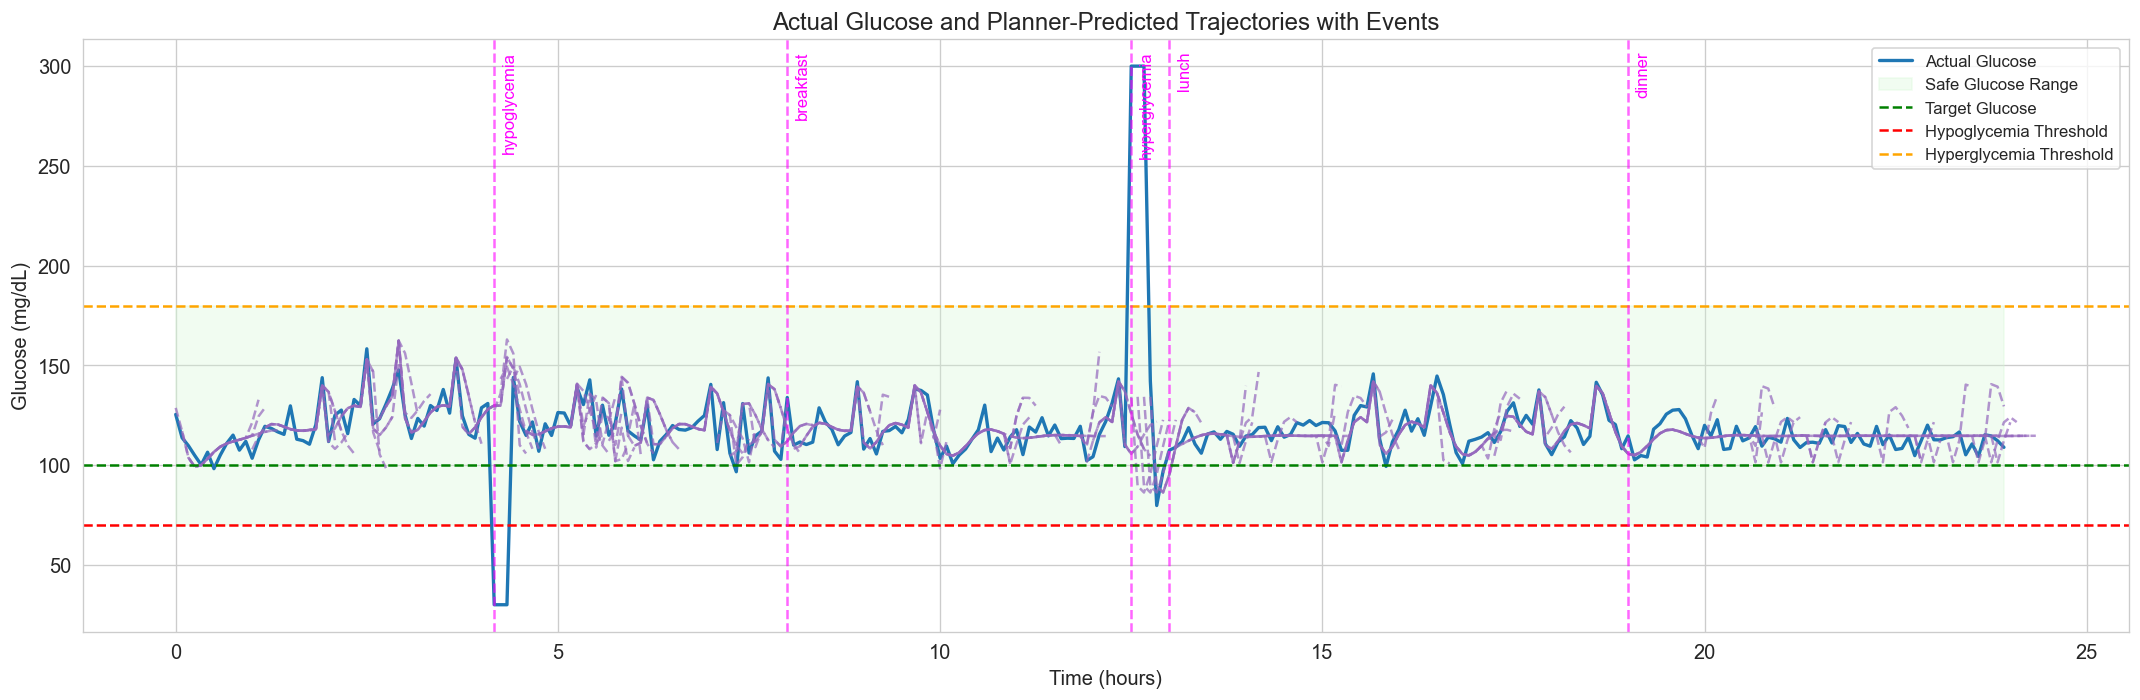

In [83]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# --- Helper to convert normalized action to text ---
def action_to_text(action, twin, step_minutes=5):
    meal_cat, mode, intensity, duration = twin._continuous_to_discrete(action)
    parts = []
    if meal_cat > 0:
        parts.append(f"Meal {meal_cat}")
    if mode == 1:
        parts.append(f"Exercise intensity {intensity}, duration {duration*step_minutes} min")
    if not parts:
        parts.append("Maintain routine")
    return ", ".join(parts)

# --- Simulation parameters ---
SIMULATION_MINUTES = 1440  # 24 hours
STEP_MINUTES = 5
TOTAL_STEPS = SIMULATION_MINUTES // STEP_MINUTES

meal_schedule = {"breakfast": 8*60, "lunch": 13*60, "dinner": 19*60}
neutral_action = np.array([0,0,0,0], dtype=np.float32)

# Inject extreme events
hypo_step = 50
hyper_step = 150
freeze_steps = 3

# --- Initialize environment, SAC model, and hybrid planner ---
env = CustomGlucoseDynamicsEnvBox(random_events=False, weight=70.0, Gb=90.0, Ib=5.7)
obs, _ = env.reset()

from stable_baselines3 import SAC
model = SAC.load("sac_glucose_model.zip")

twin = DigitalTwinForSAC(weight=70.0, Gb=90.0, Ib=5.7, dt=STEP_MINUTES)
planner = HybridLookaheadPolicyWrapper(
    sac_model=model,
    digital_twin=twin,
    horizon=6,
    candidates=5,
    target_glucose=100.0
)

# --- Storage for plotting ---
glucose_history = []
time_history = []
event_markers = []
planner_predictions = []

# Freeze tracker for injected events
freeze_counter = 0
injected_glucose = None

# --- Simulation loop ---
for step in range(TOTAL_STEPS):
    current_time = step * STEP_MINUTES
    hhmm = str(timedelta(minutes=current_time))[:-3]

    # Inject extreme glucose events
    if step == hypo_step:
        injected_glucose = 30.0
        env.simulator_state[0] = injected_glucose
        freeze_counter = freeze_steps
        event_markers.append((current_time, "hypoglycemia"))
        print(f"[{hhmm}] ⚠️ Hypoglycemia injected! Glucose={injected_glucose}")
    if step == hyper_step:
        injected_glucose = 300.0
        env.simulator_state[0] = injected_glucose
        freeze_counter = freeze_steps
        event_markers.append((current_time, "hyperglycemia"))
        print(f"[{hhmm}] ⚠️ Hyperglycemia injected! Glucose={injected_glucose}")

    # Planner predicts next action
    action, mode = planner.predict(obs, env_state=env.clone_state(), deterministic=True)
    suggested_text = action_to_text(action, twin)

    # Generate predicted trajectory for plotting
    traj_obs, _ = twin.rollout_from_env_state(env.clone_state(), action, policy=model, horizon=6)
    planner_predictions.append((current_time, traj_obs[:,0]))

    # Determine applied action
    if freeze_counter > 0:
        obs[0] = injected_glucose
        freeze_counter -= 1
    else:
        # Apply meal if scheduled
        for meal_name, meal_time in meal_schedule.items():
            if current_time == meal_time:
                obs, _, _, _, _ = env.force_action(meal_category=3)
                twin.sync_from_env_state(env.clone_state())
                event_markers.append((current_time, meal_name))
                break
        else:
            obs, _, terminated, truncated, _ = env.step(action)
            twin.sync_from_env_state(env.clone_state())

    glucose_history.append(obs[0])
    time_history.append(current_time)

    print(f"[{hhmm}] Glucose={obs[0]:.1f} mg/dL | Mode={mode} | Applied={action} | Suggested={suggested_text}")

# --- Plot results ---
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'figure.dpi': 120})

plt.figure(figsize=(18,6))

# --- Plot actual glucose trajectory ---
plt.plot(np.array(time_history)/60, glucose_history, 
         label="Actual Glucose", color="#1f77b4", linewidth=2)

# --- Plot planner-predicted trajectories ---
for start_time, pred in planner_predictions:
    hours = (np.arange(len(pred))*STEP_MINUTES + start_time)/60
    plt.plot(hours, pred, color='#9467bd', linestyle='--', alpha=0.7, linewidth=1.5, label='_nolegend_')

# --- Highlight safe range ---
plt.fill_between(np.array(time_history)/60, planner.SAFE_LOW, planner.SAFE_HIGH, 
                 color="#d3f8d3", alpha=0.3, label="Safe Glucose Range")

# --- Target and thresholds ---
plt.axhline(100, color='green', linestyle='--', linewidth=1.5, label='Target Glucose')
plt.axhline(planner.SAFE_LOW, color='red', linestyle='--', linewidth=1.5, label='Hypoglycemia Threshold')
plt.axhline(planner.SAFE_HIGH, color='orange', linestyle='--', linewidth=1.5, label='Hyperglycemia Threshold')

# Get current y-axis limits
ymin, ymax = plt.ylim()
label_height = ymax - 0.02 * (ymax - ymin)  # slightly below the top

# --- Plot events ---
for t, label in event_markers:
    plt.axvline(t/60, color='magenta', linestyle='--', alpha=0.6)
    plt.text(t/60 + 0.1, label_height, label, rotation=90,
             color='magenta', fontsize=10, verticalalignment='top')

# --- Labels & legend ---
plt.xlabel("Time (hours)")
plt.ylabel("Glucose (mg/dL)")
plt.title("Actual Glucose and Planner-Predicted Trajectories with Events")
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()